In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [289]:
# Load the dataset
df=pd.read_csv('train.csv')

In [385]:
df= df[df['SalePrice'] < 600000]


In [386]:
correlation_matrix = df.corr(numeric_only=True)
correlation_with_target = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)
print(correlation_with_target.head(25))  # Top 20 features


SalePrice         1.000000
OverallQual_sq    0.821250
OverallQual       0.802424
GrLivArea         0.686872
GarageCars        0.654418
GarageArea        0.633607
GrLivArea_sq      0.605385
TotalBsmtSF       0.596771
1stFlrSF          0.589676
FullBath          0.553014
YearBuilt         0.543898
YearRemodAdd      0.531708
TotRmsAbvGrd      0.510964
GarageYrBlt       0.506321
Fireplaces        0.469693
TotalBsmtSF_sq    0.444308
MasVnrArea        0.442144
BsmtFinSF1        0.357076
LotFrontage       0.339320
OpenPorchSF       0.332686
WoodDeckSF        0.331999
2ndFlrSF          0.292447
HalfBath          0.284007
LotArea           0.252156
BsmtFullBath      0.236628
Name: SalePrice, dtype: float64


In [387]:
selected_features = df[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
                        '1stFlrSF', 'FullBath', 'YearBuilt',
                        'TotRmsAbvGrd', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea','LotFrontage',
                        'LotArea', 'GarageArea', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2','2ndFlrSF','GarageYrBlt',
                        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea']]
Y = df['SalePrice']


In [388]:
def one_hot_encode_df(df):
    return pd.get_dummies(df, drop_first=True) 


In [389]:
selected_features= one_hot_encode_df(selected_features)

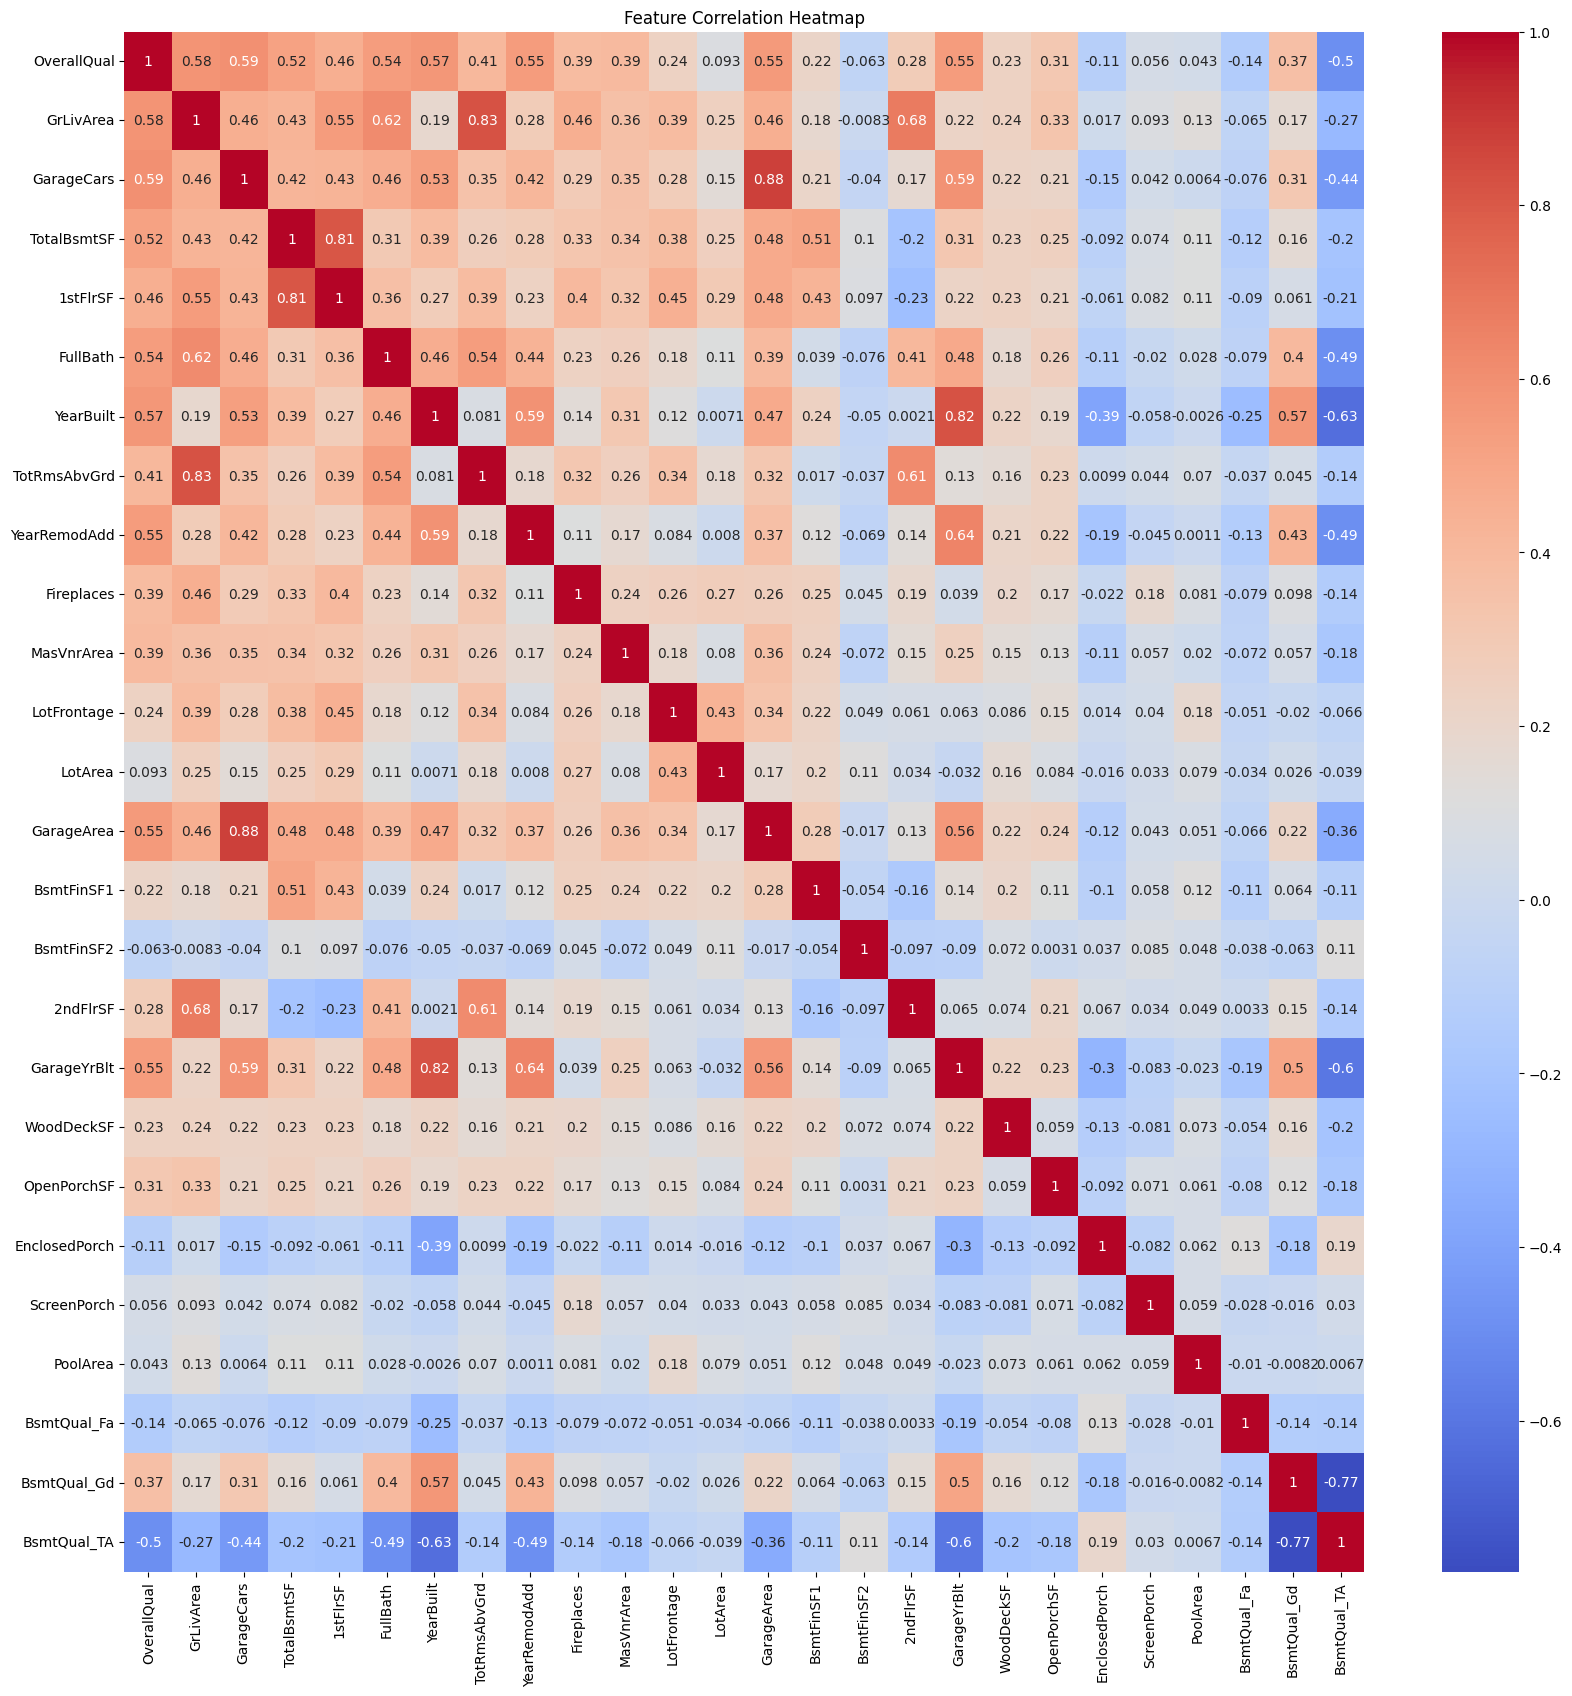

In [390]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = selected_features.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [391]:
selected_features.isnull().values.any()
# Fill missing values with the mean of each column
selected_features.fillna(selected_features.mean(), inplace=True)

In [392]:
X=selected_features

In [393]:
def feature_scaling(X_train, X_test):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    for col in X_train.columns:
        mean = X_train[col].mean()
        std = X_train[col].std()
        X_train_scaled[col] = (X_train[col] - mean) / (std + 1e-8)
        X_test_scaled[col] = (X_test[col] - mean) / (std + 1e-8)  
    return X_train_scaled, X_test_scaled

In [394]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

y_train_log = np.log1p(y_train)  
y_test_log = np.log1p(y_test)


In [395]:
X_train_scaled, X_test_scaled = feature_scaling(X_train, X_test)

In [396]:
#for training Data
X_b=np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
# for testing data
X_b_test=np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))
#for weights and bias
theta=np.zeros(X_b.shape[1])

In [397]:
#predictions:
def predict(X, theta):
    return np.dot(X, theta)

In [398]:
#compute
def compute_cost(X,Y,theta):
    n=len(Y)
    prediction=predict(X, theta)
    cost = (1/(2*n)) * np.sum((prediction - Y) ** 2)
    return cost



In [399]:
def GradientDescent(X,Y,theta,learning_rate,epochs):
    n=len(Y)
    cost_history=[]
    for epoch in range(epochs):
        predictions=predict(X,theta)
        errors=predictions-Y
        gradient=(1/n) * np.dot(X.T, errors)
        theta-=learning_rate * gradient
        cost=compute_cost(X, Y, theta)
        cost_history.append(cost)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Cost: {cost:.10f}')
    return theta, cost_history

In [400]:
learning_rate = 0.01
epochs = 1000
theta_final, cost_history = GradientDescent(X_b, y_train_log, theta, learning_rate, epochs)

Epoch 0, Cost: 70.9157445789


Epoch 100, Cost: 9.5055322688
Epoch 200, Cost: 1.2840826812
Epoch 300, Cost: 0.1823602287
Epoch 400, Cost: 0.0346393837
Epoch 500, Cost: 0.0147842799
Epoch 600, Cost: 0.0120859037
Epoch 700, Cost: 0.0117002311
Epoch 800, Cost: 0.0116326581
Epoch 900, Cost: 0.0116127670


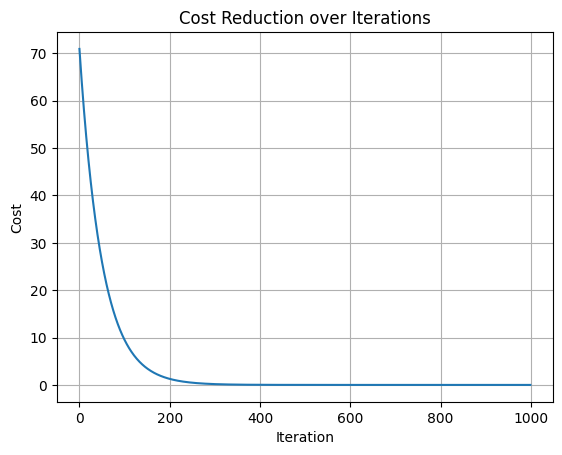

In [401]:
plt.plot(cost_history)
plt.title("Cost Reduction over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


In [402]:
y_pred_log = predict(X_b_test, theta_final)
predictions = np.expm1(y_pred_log)  # reverse the log transform

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print(f"Test MSE: {mse}")

print(f"Test RMSE: {rmse}")
print(f"Test R²: {r2}")



Test MSE: 649079354.2643495
Test RMSE: 25477.03582178173
Test R²: 0.866312104519147


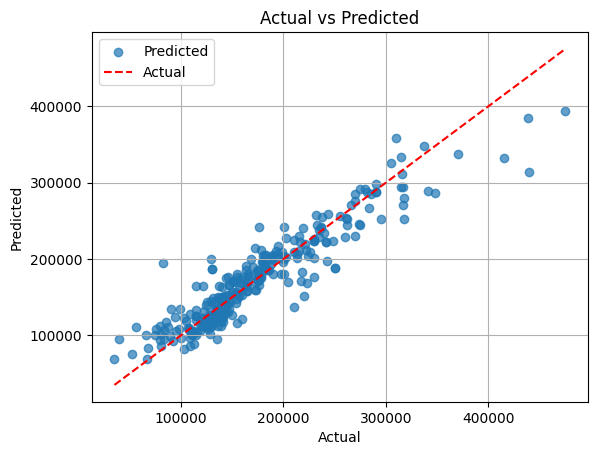

In [403]:
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(['Predicted', 'Actual'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()


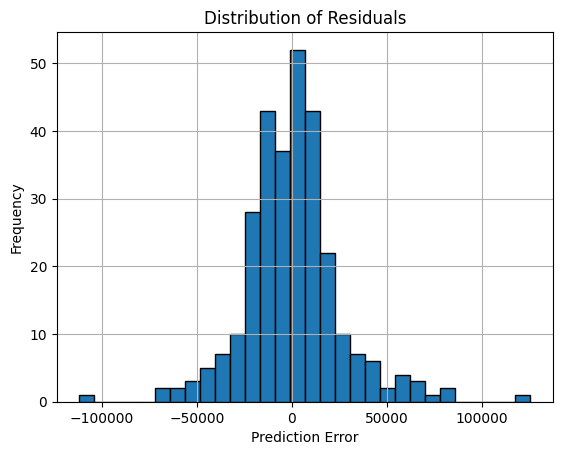

In [404]:
residuals = y_test - predictions
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()